Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}

Reporte de clasificación:
                     precision    recall  f1-score   support

      caminar_hacia       0.97      0.96      0.96       607
    caminar_regreso       0.99      0.99      0.99       894
     girar_20241124       0.97      0.95      0.96       821
levantarse_20241124       0.64      0.59      0.61       401
  sentarse_20241124       0.68      0.75      0.71       538

           accuracy                           0.88      3261
          macro avg       0.85      0.85      0.85      3261
       weighted avg       0.88      0.88      0.88      3261



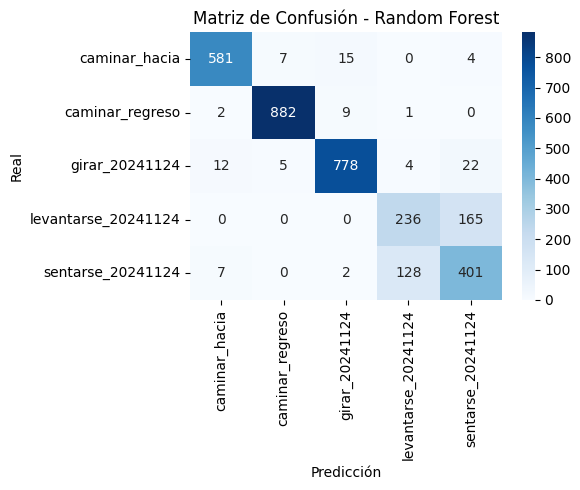

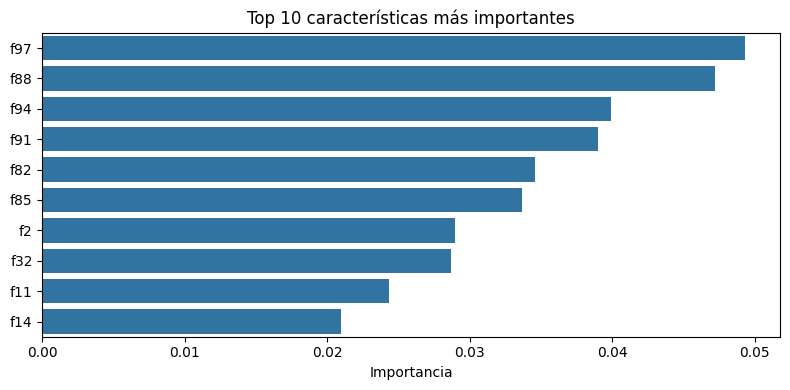


Todo guardado en la carpeta 'modelo_rf_output'


In [4]:
import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Crear carpeta de salida
OUTPUT_DIR = "modelo_rf_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. Cargar archivos CSV y dividir por video
csv_dir = "../dataset_landmarks"
csv_files = glob(os.path.join(csv_dir, "*.csv"))
np.random.seed(42)
np.random.shuffle(csv_files)

split_idx = int(0.8 * len(csv_files))
train_files = csv_files[:split_idx]
test_files = csv_files[split_idx:]

train_df = pd.concat([pd.read_csv(f) for f in train_files], ignore_index=True)
test_df = pd.concat([pd.read_csv(f) for f in test_files], ignore_index=True)

# 2. Preprocesamiento
for df_ in [train_df, test_df]:
    df_.drop(columns=[c for c in df_.columns if 'vis' in c or c == 'frame'], inplace=True)

le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
test_df['label'] = le.transform(test_df['label'])

X_train, y_train = train_df.drop(columns=['label']), train_df['label']
X_test, y_test = test_df.drop(columns=['label']), test_df['label']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3. Entrenamiento con GridSearchCV (Random Forest más simple)
param_grid = {
    'n_estimators': [100],
    'max_depth': [5, 10],
    'min_samples_leaf': [5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("Mejores hiperparámetros:", grid.best_params_)

# 4. Evaluación
y_pred = best_rf.predict(X_test)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 5. Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 6. Importancia de características
importances = best_rf.feature_importances_
top_idx = importances.argsort()[-10:][::-1]
top_features = [X_train.columns[i] if hasattr(X_train, 'columns') else f"f{i}" for i in top_idx]

plt.figure(figsize=(8, 4))
sns.barplot(x=importances[top_idx], y=top_features)
plt.title("Top 10 características más importantes")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

# 7. Guardar modelo y transformadores
joblib.dump(best_rf, os.path.join(OUTPUT_DIR, "modelo_rf.pkl"))
joblib.dump(scaler, os.path.join(OUTPUT_DIR, "scaler.pkl"))
joblib.dump(le, os.path.join(OUTPUT_DIR, "label_encoder.pkl"))

print(f"\nTodo guardado en la carpeta '{OUTPUT_DIR}'")
